# Obtaining the laser line width data

This is a jupyter notebook to see if the laser line width can be plotted

In [3]:
# . Honours Module Folder
# ├ FYPLibrary
# | ├ file_reading.py
# | └ IQ_demod.py
# └ Sub Project folder i.e.: os.path.abspath('')
#   ├ this notebook(.ipynb)
#   └ traces
#     └ laserwidth-1km.dat

# Initialization: Directory appending for my system. Vary the directories as necessary.
import sys
import os.path
# Add the FYPLibrary folder in the same level as this folder.
parent_dir = os.path.dirname(os.path.abspath(''))
if os.path.join(parent_dir, 'FYPLibrary') not in sys.path:
    sys.path.append(os.path.join(parent_dir, 'FYPLibrary'))
del parent_dir

# from pprint import pprint
# pprint(sys.path)

# within this jupyter notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy import pi
from scipy.optimize import curve_fit

# import matplotlib.dates as mdates
# import matplotlib.units as munits


In [4]:
def get_files():
    # uses tkinter to get the paths. returns all files as selected by UI
    # tkinter will not allow for extracting files from multiple folders
    import tkinter as tk
    from tkinter import filedialog

    root = tk.Tk()
    root.withdraw()
    fs = filedialog.askopenfilenames(initialdir= os.path.dirname(os.path.abspath('')), 
        title="Select files")
    return fs

def get_folder():
    # uses tkinter to get a folder
    import tkinter as tk
    from tkinter import filedialog

    root = tk.Tk()
    root.withdraw()
    my_dir = filedialog.askdirectory(initialdir= os.path.dirname(os.path.abspath('')), 
        title="Select directory")
    return my_dir

We pull put the processedLogs txt file first.

In [5]:
# Step 1: Change the name to which the folder you wish to read from
# Yield all files in batch folder
file = os.path.join(os.path.abspath(''), "traces", "laserwidth-1km.dat")

In [6]:
data_table = pd.read_csv(file, sep= '\s+', header= None, names = ('freq_v', 'dBm_v'))

In [7]:
data_table

,freq_v,dBm_v
0,1.312500e+08,-66.328705
1,1.312817e+08,-66.329117
2,1.313135e+08,-66.579544
3,1.313452e+08,-66.583237
4,1.313770e+08,-66.546165
...,...,...
626,1.511230e+08,-69.454544
627,1.511548e+08,-69.437592
628,1.511865e+08,-68.342941
629,1.512183e+08,-69.382378


In [8]:
freq = data_table['freq_v'].values
freq_MHz = freq / 1e6
dBm = data_table['dBm_v'].values
yvals = np.power(10, dBm)

In [ ]:
def r_squared(predicted_y, data_y):
    absE = predicted_y - data_y
    return 1.0 - (np.var(absE)/np.var(data_y))

def adjusted_r_squared(predicted_y, data_y, p):
    # p is the number of explainatory variables
    # print(f"[Debug] {predicted_y.size = }")
    return 1- (1-r_squared(predicted_y, data_y)) \
        *(predicted_y.size - 1)/(predicted_y.size - p)
        
def my_cauchy(x,A,mu,gamma):
    return A * np.power(gamma, 2)/(np.power(x-mu, 2)+np.power(gamma, 2))

def my_cauchy2(x, gamma, a , b):
    return b+10*np.log10(gamma**2/((x-a)**2+gamma**2))

In [ ]:
print(freq_MHz.size)
print(f"{freq_MHz[0] = }")
print(yvals.size)
print(f"{yvals[0] = }")
print(f"{np.power(10, dBm[0]) = }")

631
freq_MHz[0] = 131.25
631
yvals[0] = 4.6913211705524576e-67
np.power(10, dBm[0]) = 4.6913211705524576e-67


In [ ]:
# cauchy_popt, cauchy_pcov = curve_fit(my_cauchy, freq_MHz, yvals,
#     p0 = [np.power(10,-35.922), 141.214, 245e3],
#     bounds= ((0,0,0), (np.inf, np.inf, np.inf)))
my_p0 = [245115, 141.214e6, -35.9321]
cauchy_popt, cauchy_pcov = curve_fit(my_cauchy2, freq, dBm,
    p0= my_p0)
print(cauchy_popt)
cauchy_adjr = adjusted_r_squared(my_cauchy2(freq, *cauchy_popt), dBm, 3)
print(f"{cauchy_adjr = }")

[ 2.45827819e+05  1.41203084e+08 -3.59563380e+01]
cauchy_adjr = 0.9814678148432997


Now trying to plot std_dev against time

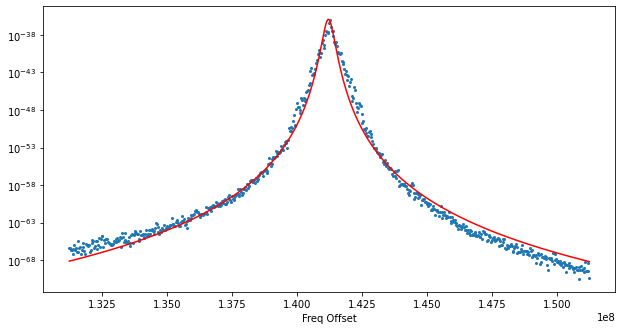

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.scatter(freq, 10**dBm, s= 4)
ax.plot(freq, 10**my_cauchy2(freq, *my_p0), color = 'red')
# ax.scatter(freq_MHz, yvals)
# ax.plot(freq_MHz, my_cauchy(freq_MHz, *cauchy_popt), lw=1, color= 'red')
ax.set_yscale('log')
ax.set_xlabel('Freq Offset', usetex= False)
fig.set_size_inches(11.75-1.5, 1*(8.25-2 - 1))

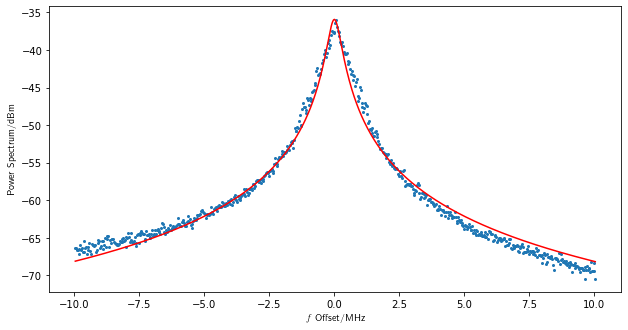

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1)

mu = 141.214
my_p02 = [245115e-6, 0, -35.9321]
ax.plot(freq_MHz-mu, my_cauchy2(freq_MHz-mu, *my_p02), color = 'red')
ax.scatter(freq_MHz-mu, dBm, s= 4)
# ax.scatter(freq_MHz, yvals)
# ax.plot(freq_MHz, my_cauchy(freq_MHz, *cauchy_popt), lw=1, color= 'red')
# ax.set_yscale('log')
ax.set_ylabel(r'Power Spectrum/dBm', usetex= True)
ax.set_xlabel(r'$f$ Offset/MHz', usetex= True)
fig.set_size_inches(11.75-1.5, 1*(8.25-2 - 1))